# Herschel Stripe 82 master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP mater catalogue on Herschel Stripe 82.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
ceb6b33 (Wed Jun 28 18:07:57 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [5]:
hsc = Table.read("{}/HSC-SSP.fits".format(TMP_DIR))
vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))
vics82 = Table.read("{}/VICS82.fits".format(TMP_DIR))
las = Table.read("{}/UKIDSS-LAS.fits".format(TMP_DIR))
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))
shela = Table.read("{}/SHELA.fits".format(TMP_DIR))
spies= Table.read("{}/SpIES.fits".format(TMP_DIR))

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones: HSC, VHS, VICS82, UKIDSS-LAS, PanSTARRS, SHELA, SpIES.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### HSC

In [6]:
master_catalogue = hsc
master_catalogue['hsc_ra'].name = 'ra'
master_catalogue['hsc_dec'].name = 'dec'

### Add VHS

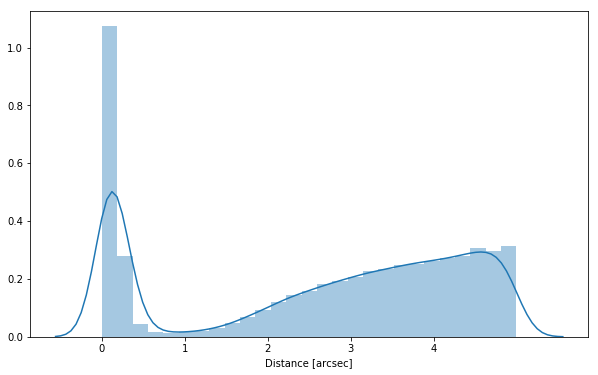

In [7]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vhs['vhs_ra'], vhs['vhs_dec'])
)

In [8]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vhs, "vhs_ra", "vhs_dec", radius=0.8*u.arcsec)

### Add VICS82

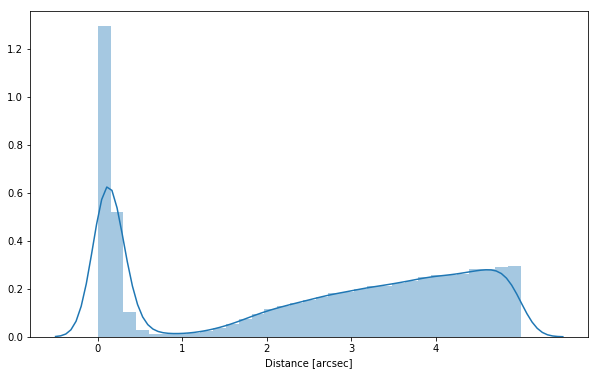

In [9]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vics82['vics82_ra'], vics82['vics82_dec'])
)

In [10]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vics82, "vics82_ra", "vics82_dec", radius=0.8*u.arcsec)

### Add LAS

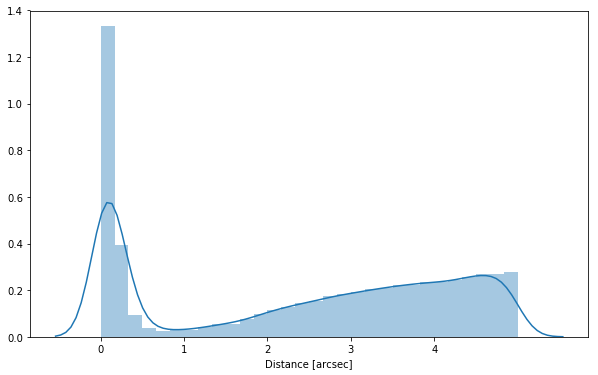

In [16]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(las['las_ra'], las['las_dec'])
)

In [12]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, las, "las_ra", "las_dec", radius=0.8*u.arcsec)

### Add PanSTARRS

In [17]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(ps1['ps1_rac'], ps1['ps1_dec'])
)

AttributeError: 'Quantity' object has no 'arcsec' member

In [21]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, ps1, "ps1_ra", "ps1_dec", radius=0.8*u.arcsec)

ValueError: Duplicate column names

### Add SHELA

In [14]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(shela['shela_ra'], shela['shela_dec'])
)

AttributeError: 'Quantity' object has no 'arcsec' member

In [19]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, shela, "shela_ra", "shela_dec", radius=1.*u.arcsec)

### Add SpIES

In [15]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(spies['spies_ra'], spies['spies_dec'])
)

AttributeError: 'Quantity' object has no 'arcsec' member

In [20]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, spies, "spies_ra", "spies_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [22]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [23]:
master_catalogue[:10].show_in_notebook()

idx,hsc_id,ra,dec,m_app_suprime_g,merr_app_suprime_g,m_suprime_g,merr_suprime_g,m_app_suprime_r,merr_app_suprime_r,m_suprime_r,merr_suprime_r,m_app_suprime_i,merr_app_suprime_i,m_suprime_i,merr_suprime_i,m_app_suprime_z,merr_app_suprime_z,m_suprime_z,merr_suprime_z,m_app_suprime_y,merr_app_suprime_y,m_suprime_y,merr_suprime_y,m_app_suprime_n816,merr_app_suprime_n816,m_suprime_n816,merr_suprime_n816,m_app_suprime_n921,merr_app_suprime_n921,m_suprime_n921,merr_suprime_n921,f_app_suprime_g,ferr_app_suprime_g,f_suprime_g,ferr_suprime_g,flag_suprime_g,f_app_suprime_r,ferr_app_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_app_suprime_i,ferr_app_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_app_suprime_z,ferr_app_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_app_suprime_y,ferr_app_suprime_y,f_suprime_y,ferr_suprime_y,flag_suprime_y,f_app_suprime_n816,ferr_app_suprime_n816,f_suprime_n816,ferr_suprime_n816,flag_suprime_n816,f_app_suprime_n921,ferr_app_suprime_n921,f_suprime_n921,ferr_suprime_n921,flag_suprime_n921,hsc_flag_cleaned,hsc_flag_gaia,flag_merged,vhs_id,vhs_stellarity,m_vhs_y,merr_vhs_y,m_ap_vhs_y,merr_ap_vhs_y,m_vhs_j,merr_vhs_j,m_ap_vhs_j,merr_ap_vhs_j,m_vhs_h,merr_vhs_h,m_ap_vhs_h,merr_ap_vhs_h,m_vhs_k,merr_vhs_k,m_ap_vhs_k,merr_ap_vhs_k,f_vhs_y,ferr_vhs_y,flag_vhs_y,f_ap_vhs_y,ferr_ap_vhs_y,f_vhs_j,ferr_vhs_j,flag_vhs_j,f_ap_vhs_j,ferr_ap_vhs_j,f_vhs_h,ferr_vhs_h,flag_vhs_h,f_ap_vhs_h,ferr_ap_vhs_h,f_vhs_k,ferr_vhs_k,flag_vhs_k,f_ap_vhs_k,ferr_ap_vhs_k,vhs_flag_cleaned,vhs_flag_gaia,vics82_id,vics82_stellarity,m_vics82_k,m_ap_vics82_k,m_vics82_j,m_ap_vics82_j,merr_vics82_k,f_vics82_k,ferr_vics82_k,flag_vics82_k,merr_ap_vics82_k,f_ap_vics82_k,ferr_ap_vics82_k,merr_vics82_j,f_vics82_j,ferr_vics82_j,flag_vics82_j,merr_ap_vics82_j,f_ap_vics82_j,ferr_ap_vics82_j,vics82_flag_cleaned,vics82_flag_gaia,las_id,m_ukidss_y,merr_ukidss_y,m_ap_ukidss_y,merr_ap_ukidss_y,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,m_ap_ukidss_h,merr_ap_ukidss_h,m_ukidss_h,merr_ukidss_h,m_ap_ukidss_k,merr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,las_stellarity,f_ukidss_y,ferr_ukidss_y,flag_ukidss_y,f_ap_ukidss_y,ferr_ap_ukidss_y,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,f_ap_ukidss_h,ferr_ap_ukidss_h,f_ukidss_h,ferr_ukidss_h,flag_ukidss_h,f_ap_ukidss_k,ferr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k,las_flag_cleaned,las_flag_gaia,ps1_id,m_ap_gpc1_g,merr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_r,merr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_i,merr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_z,merr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_y,merr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_gpc1_g,ferr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,flag_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,flag_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,flag_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,flag_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,flag_gpc1_y,ps1_flag_cleaned,ps1_flag_gaia,shela_intid,f_shela_irac1,ferr_shela_irac1,f_ap_shela_irac1,ferr_ap_shela_irac1,f_shela_irac2,ferr_shela_irac2,f_ap_shela_irac2,ferr_ap_shela_irac2,m_shela_irac1,merr_shela_irac1,flag_shela_irac1,m_ap_shela_irac1,merr_ap_shela_irac1,m_shela_irac2,merr_shela_irac2,flag_shela_irac2,m_ap_shela_irac2,merr_ap_shela_irac2,shela_flag_cleaned,shela_flag_gaia,spies_intid,f_app_spies_irac1,ferr_app_spies_irac1,f_spies_irac1,ferr_spies_irac1,spies_stellarity_irac1,f_app_spies_irac2,ferr_app_spies_irac2,f_spies_irac2,ferr_spies_irac2,spies_stellarity_irac2,m_app_spies_irac1,merr_app_spies_irac1,m_spies_irac1,merr_spies_irac1,flag_spies_irac1,m_app_spies_irac2,merr_app_spies_irac2,m_spies_irac2,merr_spies_irac2,flag_spies_irac2,spies_flag_cleaned,spies_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [24]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [25]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [26]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

master_catalogue.add_column(Column(
    data=np.nanmax([master_catalogue[column] for column in stellarity_columns], axis=0),
    name="stellarity"
))
master_catalogue.remove_columns(stellarity_columns)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


## IV - Adding E(B-V) column

In [27]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [28]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "Herschel-Stripe-82", dtype='<U18'),
                                   name="field"))

In [29]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## VI - Choosing between multiple values for the same filter

Both SHELA and SpIES provide IRAC1 and IRAC2 fluxes. SpIES seems to go deeper and neither apear to suffer from the bright drop off that affects both SERVS and SWIRE.

In [30]:
seip = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_Herschel-Stripe-82.fits")
seip_coords = SkyCoord(seip['ra'], seip['dec'])
idx, d2d, _ = seip_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
mask = d2d <= 2 * u.arcsec

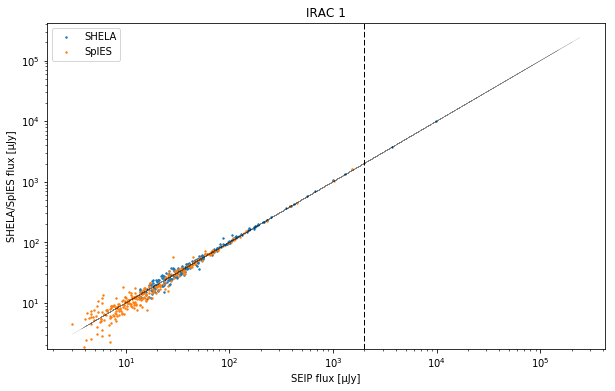

In [32]:
# servs -> shela and swire -> spies
fig, ax = plt.subplots()
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_shela_irac1'], label="SHELA", s=2.)
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_spies_irac1'], label="SpIES", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SHELA/SpIES flux [μJy]")
ax.set_title("IRAC 1")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)
ax.plot(seip['i1_f_ap1'][mask], seip['i1_f_ap1'][mask], linewidth=.1, color="black", alpha=.5);

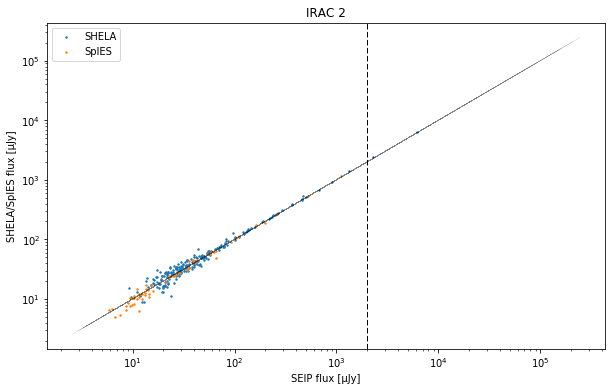

In [33]:
fig, ax = plt.subplots()
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_shela_irac2'], label="SHELA", s=2.)
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_spies_irac2'], label="SpIES", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SHELA/SpIES flux [μJy]")
ax.set_title("IRAC 2")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)

ax.plot(seip['i1_f_ap2'][mask], seip['i1_f_ap2'][mask], linewidth=.1, color="black", alpha=.5);

When both SHELA and SpIES fluxes are provided, we use the SpIES flux.

We create a table indicating for each source the origin on the IRAC1 and IRAC2 fluxes that will be saved separately.

In [35]:
irac_origin = Table()
irac_origin.add_column(master_catalogue['help_id'])

In [40]:
# IRAC1 aperture flux and magnitudes
has_shela = ~np.isnan(master_catalogue['f_ap_shela_irac1'])
has_spies = ~np.isnan(master_catalogue['f_ap_spies_irac1'])
has_both = has_shela & has_spies

print("{} sources with SHELA flux".format(np.sum(has_shela)))
print("{} sources with SpIES flux".format(np.sum(has_spies)))
print("{} sources with SHELA and SpIES flux".format(np.sum(has_both)))

use_shela = has_shela
use_spies = (has_spies & ~has_shela)

print("{} sources for which we use SHELA".format(np.sum(use_shela)))
print("{} sources for which we use SpIES".format(np.sum(use_spies)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_shela] = master_catalogue['f_ap_shela_irac1'][use_shela]
f_ap_irac[use_spies] = master_catalogue['f_ap_spies_irac1'][use_spies]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_shela] = master_catalogue['ferr_ap_shela_irac1'][use_shela]
ferr_ap_irac[use_spies] = master_catalogue['ferr_ap_spies_irac1'][use_spies]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_shela] = master_catalogue['m_ap_shela_irac1'][use_shela]
m_ap_irac[use_spies] = master_catalogue['m_ap_spies_irac1'][use_spies]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_shela] = master_catalogue['merr_ap_shela_irac1'][use_shela]
merr_ap_irac[use_spies] = master_catalogue['merr_ap_spies_irac1'][use_spies]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_ap_irac1"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_ap_irac1"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_ap_irac1"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_ap_irac1"))

master_catalogue.remove_columns(['f_ap_shela_irac1', 'f_ap_spies_irac1', 
                                 'ferr_ap_shela_irac1', 'ferr_ap_spies_irac1', 
                                 'm_ap_shela_irac1', 'm_ap_spies_irac1',
                                 'merr_ap_shela_irac1', 'merr_ap_spies_irac1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_shela] = "SHELA"
origin[use_spies] = "SpIES"
irac_origin.add_column(Column(data=origin, name="IRAC1_ap"))

KeyError: 'f_ap_shela_irac1'

In [47]:
# IRAC1 total flux and magnitudes
has_shela = ~np.isnan(master_catalogue['f_shela_irac1'])
has_spies = ~np.isnan(master_catalogue['f_spies_irac1'])
has_both = has_shela & has_spies

print("{} sources with SHELA total flux".format(np.sum(has_shela)))
print("{} sources with SpIES total flux".format(np.sum(has_spies)))
print("{} sources with SHELA and SpIES total flux".format(np.sum(has_both)))

use_shela = has_shela
use_spies = (has_spies & ~has_shela)

print("{} sources for which we use SHELA".format(np.sum(use_shela)))
print("{} sources for which we use SpIES".format(np.sum(use_spies)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_shela] = master_catalogue['f_shela_irac1'][use_shela]
f_ap_irac[use_spies] = master_catalogue['f_spies_irac1'][use_spies]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_shela] = master_catalogue['ferr_shela_irac1'][use_shela]
ferr_ap_irac[use_spies] = master_catalogue['ferr_spies_irac1'][use_spies]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_shela] = master_catalogue['m_shela_irac1'][use_shela]
m_ap_irac[use_spies] = master_catalogue['m_spies_irac1'][use_spies]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_shela] = master_catalogue['merr_shela_irac1'][use_shela]
merr_ap_irac[use_spies] = master_catalogue['merr_spies_irac1'][use_spies]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_irac1"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_irac1"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_irac1"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_irac1"))

master_catalogue.remove_columns(['f_shela_irac1', 'f_spies_irac1', 
                                 'ferr_shela_irac1', 'ferr_spies_irac1', 
                                 'm_shela_irac1', 'm_spies_irac1',
                                 'merr_shela_irac1', 'merr_spies_irac1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_shela] = "SHELA"
origin[use_spies] = "SpIES"
irac_origin.add_column(Column(data=origin, name="IRAC1_total"))

67868 sources with SHELA total flux
62528 sources with SpIES total flux
21651 sources with SHELA and SpIES total flux
67868 sources for which we use SHELA
40877 sources for which we use SpIES


In [48]:
# IRAC2 aperture flux and magnitudes
has_shela = ~np.isnan(master_catalogue['f_ap_shela_irac2'])
has_spies = ~np.isnan(master_catalogue['f_ap_spies_irac2'])
has_both = has_shela & has_spies

print("{} sources with SHELA flux".format(np.sum(has_shela)))
print("{} sources with SpIES flux".format(np.sum(has_spies)))
print("{} sources with SHELA and SpIES flux".format(np.sum(has_both)))

use_shela = has_shela
use_spies = (has_spies & ~has_shela)

print("{} sources for which we use SHELA".format(np.sum(use_shela)))
print("{} sources for which we use SpIES".format(np.sum(use_spies)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_shela] = master_catalogue['f_ap_shela_irac2'][use_shela]
f_ap_irac[use_spies] = master_catalogue['f_ap_spies_irac2'][use_spies]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_shela] = master_catalogue['ferr_ap_shela_irac2'][use_shela]
ferr_ap_irac[use_spies] = master_catalogue['ferr_ap_spies_irac2'][use_spies]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_shela] = master_catalogue['m_ap_shela_irac2'][use_shela]
m_ap_irac[use_spies] = master_catalogue['m_ap_spies_irac2'][use_spies]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_shela] = master_catalogue['merr_ap_shela_irac2'][use_shela]
merr_ap_irac[use_spies] = master_catalogue['merr_ap_spies_irac2'][use_spies]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_ap_irac2"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_ap_irac2"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_ap_irac2"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_ap_irac2"))

master_catalogue.remove_columns(['f_ap_shela_irac2', 'f_ap_spies_irac2', 
                                 'ferr_ap_shela_irac2', 'ferr_ap_spies_irac2', 
                                 'm_ap_shela_irac2', 'm_ap_spies_irac2',
                                 'merr_ap_shela_irac2', 'merr_ap_spies_irac2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_shela] = "SHELA"
origin[use_spies] = "SpIES"
irac_origin.add_column(Column(data=origin, name="IRAC2_ap"))

KeyError: 'f_ap_spies_irac2'

In [49]:
# IRAC2 total flux and magnitudes
has_shela = ~np.isnan(master_catalogue['f_shela_irac2'])
has_spies = ~np.isnan(master_catalogue['f_spies_irac2'])
has_both = has_shela & has_spies

print("{} sources with SHELA total flux".format(np.sum(has_shela)))
print("{} sources with SpIES total flux".format(np.sum(has_spies)))
print("{} sources with SHELA and SpIES total flux".format(np.sum(has_both)))

use_shela = has_shela
use_spies = (has_spies & ~has_shela)

print("{} sources for which we use SHELA".format(np.sum(use_shela)))
print("{} sources for which we use SpIES".format(np.sum(use_spies)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_shela] = master_catalogue['f_shela_irac2'][use_shela]
f_ap_irac[use_spies] = master_catalogue['f_spies_irac2'][use_spies]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_shela] = master_catalogue['ferr_shela_irac2'][use_shela]
ferr_ap_irac[use_spies] = master_catalogue['ferr_spies_irac2'][use_spies]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_shela] = master_catalogue['m_shela_irac2'][use_shela]
m_ap_irac[use_spies] = master_catalogue['m_spies_irac2'][use_spies]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_shela] = master_catalogue['merr_shela_irac2'][use_shela]
merr_ap_irac[use_spies] = master_catalogue['merr_spies_irac2'][use_spies]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_irac2"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_irac2"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_irac2"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_irac2"))

master_catalogue.remove_columns(['f_shela_irac2', 'f_spies_irac2', 
                                 'ferr_shela_irac2', 'ferr_spies_irac2', 
                                 'm_shela_irac2', 'm_spies_irac2',
                                 'merr_shela_irac2', 'merr_spies_irac2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_shela] = "SHELA"
origin[use_spies] = "SpIES"
irac_origin.add_column(Column(data=origin, name="IRAC2_total"))

67868 sources with SHELA total flux
62528 sources with SpIES total flux
21651 sources with SHELA and SpIES total flux
67868 sources for which we use SHELA
40877 sources for which we use SpIES


In [ ]:
irac_origin.write("{}/herschel-stripe-82_irac_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

## VII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelenght domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.*

In [ ]:
hsc_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_Herschel-Stripe-82_MOC.fits")
vhs_moc = MOC(filename="../../dmu0/dmu0_VISTA-VHS/data/VHS_Herschel-Stripe-82_MOC.fits")
vics82_moc = MOC(filename="../../dmu0/dmu0_VICS82/data/VICS82_FULL_SDSS_FEB2017_K22_HELP-coverage_intIDs_MOC.fits")
las_moc = MOC(filename="../../dmu0/dmu0_UKIDSS-LAS/data/UKIDSS-LAS_Herschel-Stripe-82_MOC.fits")
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_Herschel-Stripe-82_MOC.fits")
shela_moc = MOC(filename="../../dmu0/dmu0_SHELA/data/shela_irac_v1.3_flux_cat_MOC.fits")
spies_moc = MOC(filename="../../dmu0/dmu0_SpIES/data/SpIES_ch1andch2_HELP-coverage_MOC.fits")

In [ ]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    hsc_moc + ps1_moc) 

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    las_moc + vics82_moc + vhs_moc
)

was_observed_mir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    shela_moc + spies_moc
)

In [ ]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelenght domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [ ]:
#TODO check detection bands
nb_optical_flux = (
    1 * ~np.isnan(master_catalogue['f_suprime_g']) +
    1 * ~np.isnan(master_catalogue['f_suprime_r']) +
    1 * ~np.isnan(master_catalogue['f_suprime_i']) +
    1 * ~np.isnan(master_catalogue['f_suprime_z']) +
    1 * ~np.isnan(master_catalogue['f_suprime_y']) +
    1 * ~np.isnan(master_catalogue['f_suprime_n921']) +
    1 * ~np.isnan(master_catalogue['f_suprime_n816']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_g']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_r']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_i']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_z']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_y'])
)

nb_nir_flux = (
    1 * ~np.isnan(master_catalogue['f_ukidss_y']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_j']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_h']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_k']) +
    1 * ~np.isnan(master_catalogue['f_vics82_j']) +
    1 * ~np.isnan(master_catalogue['f_vics82_k']) 
)

nb_mir_flux = (
    1 * ~np.isnan(master_catalogue['f_irac1']) +
    1 * ~np.isnan(master_catalogue['f_irac2']) 
)

In [ ]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

master_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

## VIII - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [ ]:
master_catalogue['help_id', 'hsc_id', 'vhs_id', 'vics82_intid', 'ps1_intid', 
                 'shela_id', 'spies_id'].write(
    "{}/master_list_cross_ident_herschel-stripe-82{}.fits".format(OUT_DIR, SUFFIX))
master_catalogue.remove_columns(['help_id', 'hsc_id', 'vhs_id', 'vics82_intid', 'ps1_intid', 
                 'shela_id', 'spies_id'])

## IX - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [ ]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## IX - Saving the catalogue

In [ ]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", "ebv"]

In [ ]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

In [ ]:
master_catalogue[columns].write("{}/master_catalogue_herschel-stripe-82{}.fits".format(OUT_DIR, SUFFIX))